## CAPTCHA image recognition
### By Ali Shannon

The data is obtained from [Kaggle](https://www.kaggle.com/fournierp/captcha-version-2-images) which provides labeled datasets for ML practice.
The goal here is to use computer vision provided by torchvision from pytorch to read and attempt to recognize lettersin in CAPTCHA images.
The only downside is that labels are not uniformly distributed so some discrepancies may occur. A larger dataset with more variations may prove helpful.

Each CAPTCHA image has exactly 5 characters and they could be letters or numbers, the labels are inferred from the training data.
If a new character is introduced, this model will not perform well since it does not have it in the dictionary of characters as explained by the encoder. For encoding I am using the scikit-learn `OneHotEncoder` class which replaces the matrix of characters into a more sparse matrix of zeros and ones.

In [3]:
from matplotlib import pyplot as plt
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from torch.nn import functional as F
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PATH = 'samples/*.png'

Import all images and labels

In [4]:
pics = {}
for image_file in glob(PATH):
    #label = image_file.split('/')[-1].split('.')[0] # linux version
    label = image_file.split('\\')[-1].split('.')[0]
    with Image.open(image_file) as pic:
        pics[label] = np.asarray(pic)


# The data needs to be array-like for train_test_split
x = list(map(transforms.ToTensor(), pics.values()))
y = list(map(list, pics.keys()))

Set up the encoder to create ones and zeros

In [5]:
encoder = OneHotEncoder().fit(y)
y_encoded = encoder.transform(y).toarray()

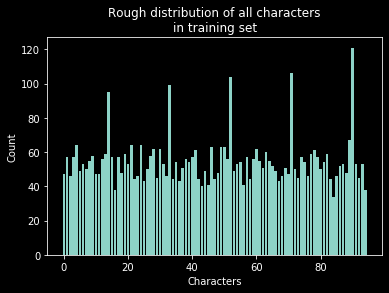

In [25]:
distribution_of_chars = np.sum(y_encoded, axis=0)
plt.bar(np.arange(len(distribution_of_chars)), distribution_of_chars)
plt.title('Rough distribution of all characters\nin trainin')
plt.xlabel('Characters')
plt.ylabel('Count')
plt.show()

Split into train and test sets

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y_encoded, test_size=0.33, random_state=42)

Tensorize all of them to prep for neural network

In [6]:
x_train = torch.stack(x_train)
x_test = torch.stack(x_test)
y_train = torch.tensor(y_train)

Define the CNN

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feats = nn.Sequential(
            nn.Conv2d(4, 24, kernel_size=2, stride=2),
            nn.AvgPool2d(kernel_size=2),
            nn.Dropout(0.2),
            nn.Conv2d(24, 48, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),
        )
        self.fc = nn.Linear(5760, 95)

    def forward(self, x):
        x = self.feats(x)
        x = x.flatten(1)
        x = self.fc(F.relu(x))
        return F.softmax(x, -1)

model = CNN()
model.double().to(DEVICE)

error = nn.BCELoss()
opt = optim.Adam(model.parameters())

Define the train function and start training.

Epoch: 100 	 loss: 0.10280555339796826
Epoch: 200 	 loss: 0.09527726726109494
Epoch: 300 	 loss: 0.0932475486697658
Epoch: 400 	 loss: 0.0918443012334607
Epoch: 500 	 loss: 0.09139890883700973
Epoch: 600 	 loss: 0.09084757545282005
Epoch: 700 	 loss: 0.0905401900598109
Epoch: 800 	 loss: 0.09017886497628548
Epoch: 900 	 loss: 0.08985160414548853
Epoch: 1000 	 loss: 0.08942246852779413


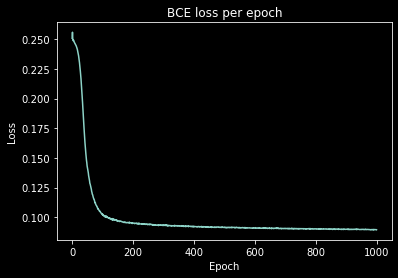

In [8]:
y_t = y_train.to(DEVICE)
x_t = x_train.double().to(DEVICE)

def train(x, y, num_epochs=1000):
    losses = []
    model.train()
    for epoch in range(1, 1 + num_epochs):
        opt.zero_grad()
        out = model(x.double().to(DEVICE))
        loss = error(out, y_t)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        if epoch % int(0.1 * num_epochs) == 0:
            print(f'Epoch: {epoch} \t loss: {loss.item()}')
    return losses

losses = train(x_t, y_t)
plt.plot(losses)
plt.title('BCE loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Run model on test set

In [9]:
with torch.no_grad():
    out = model(x_test.double().to(DEVICE)).cpu().detach().numpy()

# Decode the ones and zeros matrix
res = encoder.inverse_transform(out)
true = encoder.inverse_transform(y_test)

test_images = list(map(transforms.ToPILImage(), x_test))

Sample and show results

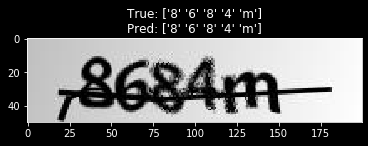

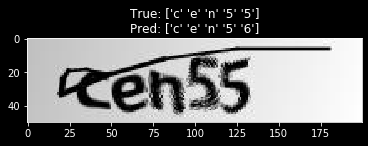

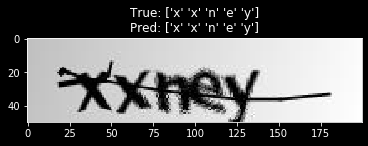

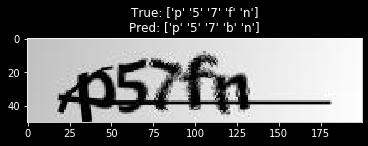

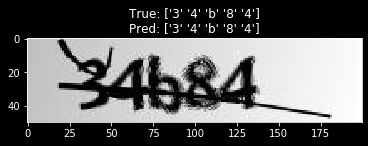

In [12]:
for s in np.random.choice(len(x_test) - 1, size=5):
    plt.tit(f'True: {true[s]}\nPred: {res[s]}')
    plt.imshow(test_images[s])
    plt.show()

Write a scoring algorithm for multilabel classifier
I chose to go with giving it partial credit for getting some characters correct even though it wouldn't pass a CAPTCHA test.

In [13]:
def multi_label_score(true, res):
    score = []
    for x, y in zip(true, res):
        if all(x == y):
            score.append(1)
        elif any(x == y):
            score.append(sum(x == y) / len(x))
        else:
            score.append(0)
    return sum(score) / len(score) * 100

print(f'Accuracy score: {multi_label_score(true, res):.4g}%')

Accuracy score: 79.3%


This is pretty good for a back of the napkin code that tries to cheat CAPTCHA